In [1]:
# Uncomment line below to install exlib
# !pip install exlib
import sys; sys.path.insert(0, "../../exlib/src")
import exlib

In [2]:
import torch
from datasets import load_dataset
from exlib.datasets.mass_maps import MassMapsDataset

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# Load data
val_dataset = MassMapsDataset(split="validation")

In [4]:
X, y = val_dataset[0:2]['input'], val_dataset[0:2]['label']

In [5]:
import openai
from getpass import getpass
import os

openai.api_key = getpass('Enter your OpenAI API key: ')
os.environ['OPENAI_API_KEY'] = openai.api_key

# client = openai.OpenAI(api_key=openai.api_key)

Enter your OpenAI API key:  ········


In [11]:
!pip install diskcache

In [15]:
from massmaps import massmap_to_pil_norm, get_llm_generated_answer, isolate_individual_features, distill_relevant_features, calculate_expert_alignment_score

In [16]:
di = 0
image = X[di]

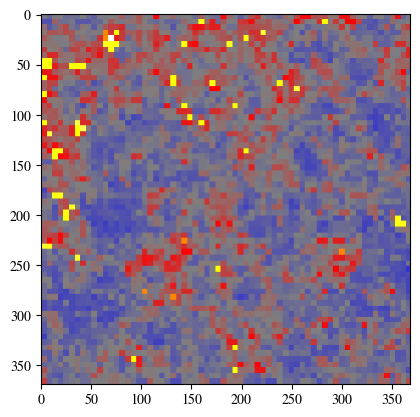

In [17]:
import matplotlib.pyplot as plt

plt.imshow(massmap_to_pil_norm(image))

In [24]:
# Generate explanation and answer at the same time
llm_generated_answer = get_llm_generated_answer(image)
llm_generated_answer

{'Explanation': 'The weak lensing map shows a predominantly dark blue background, indicating low matter density in most regions, which suggests the presence of voids. The few bright yellow and red spots indicate areas of higher matter density, likely corresponding to galaxy clusters. The sparse distribution of these clusters implies a lower overall matter density, which is consistent with a lower Omega_m value. The presence of clusters, however, suggests that the universe has some structure, which is indicative of a non-negligible sigma_8. The limited number of high-density regions suggests that while there is some clustering, it is not overly pronounced, leading to a moderate estimate for sigma_8. Based on these observations, I predict Omega_m to be around 0.3 and sigma_8 to be approximately 0.7.',
 'Answer': {'Omega_m': 0.3, 'sigma_8': 0.7}}

In [25]:
# extract atomic claims from llm explanation
raw_atomic_claims = isolate_individual_features(llm_generated_answer['Explanation'])
raw_atomic_claims

['The weak lensing map shows a predominantly dark blue background, indicating low matter density in most regions.',
 'The dark blue background suggests the presence of voids in the universe.',
 'The few bright yellow and red spots on the map indicate areas of higher matter density.',
 'The bright yellow and red spots likely correspond to galaxy clusters.',
 'The sparse distribution of galaxy clusters implies a lower overall matter density in the universe.',
 'A lower overall matter density is consistent with a lower Omega_m value.',
 'The presence of galaxy clusters suggests that the universe has some structure.',
 'The structure indicated by the presence of clusters is indicative of a non-negligible sigma_8.',
 'The limited number of high-density regions suggests that clustering is not overly pronounced.',
 'The moderate clustering leads to a moderate estimate for sigma_8.',
 'Based on the observations, Omega_m is predicted to be around 0.3.',
 'Based on the observations, sigma_8 is p

In [26]:
# extract only relevant features
atomic_claims = distill_relevant_features(image, llm_generated_answer['Answer'], raw_atomic_claims)
atomic_claims

['The weak lensing map shows a predominantly dark blue background, indicating low matter density in most regions.',
 'The dark blue background suggests the presence of voids in the universe.',
 'The few bright yellow and red spots on the map indicate areas of higher matter density.',
 'The limited number of high-density regions suggests that clustering is not overly pronounced.']

In [27]:
# calculate the expert alignment score for each relevant atomic claim
alignment_scores = calculate_expert_alignment_score(atomic_claims)
alignment_scores

{'alignment_scores': [{'claim': 'The weak lensing map shows a predominantly dark blue background, indicating low matter density in most regions.',
   'score': 4,
   'aligned_expert_knowledge': 'Spatial distribution'},
  {'claim': 'The dark blue background suggests the presence of voids in the universe.',
   'score': 5,
   'aligned_expert_knowledge': 'Voids'},
  {'claim': 'The few bright yellow and red spots on the map indicate areas of higher matter density.',
   'score': 5,
   'aligned_expert_knowledge': 'Spatial distribution'},
  {'claim': 'The limited number of high-density regions suggests that clustering is not overly pronounced.',
   'score': 3,
   'aligned_expert_knowledge': 'Clusters'}],
 'total_score': 4}